# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing all required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
# Imports
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, LSTM, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from collections import Counter
from google.colab import files
import pickle
import joblib
from keras.models import load_model

In [ ]:
labels_file = '/content/drive/MyDrive/y.txt'
embeddings_file = '/content/drive/MyDrive/x.npy'

In [ ]:
def load_dataset_files(labels_file, embeddings_file):
    x = np.load(embeddings_file)
    y = pd.read_csv(labels_file, sep = " ", header=None, names=["Complexity", "Node Number", "Language"])
    return x,y

In [ ]:
x,y = load_dataset_files(labels_file,embeddings_file)

In [ ]:
x

array([[-0.05468176,  0.127175  ,  0.0366478 , ...,  0.09731236,
        -0.107657  ,  0.08184043],
       [-0.0952346 ,  0.17503381,  0.06393544, ...,  0.1181241 ,
        -0.12556435,  0.13071893],
       [-0.13581266,  0.21943617,  0.10214286, ...,  0.1283566 ,
        -0.14471857,  0.19222681],
       ...,
       [ 0.18476942, -0.20165125, -0.23536444, ...,  0.23089787,
        -0.3212845 , -0.2662279 ],
       [ 0.25568134, -0.19382419, -0.3828221 , ...,  0.27317905,
        -0.33641592, -0.30042982],
       [ 0.78257215, -0.16311097, -0.7386889 , ...,  0.5125705 ,
        -0.17265631, -0.5655121 ]], dtype=float32)

In [ ]:
y

,Complexity,Node Number,Language
0,O(1),nodes0,C
1,O(2n),nodes0,C
2,O(2n),nodes1,C
3,O(logN),nodes0,C
4,O(logN),nodes1,C
...,...,...,...
735,O(NlogN),nodes5,Java
736,O(NlogN),nodes6,Java
737,O(NlogN),nodes7,Java
738,O(NlogN),nodes8,Java


# Method 1 (Resampling)

In [ ]:
def method1(x,y,labels_file):
    # Creating Dataframes
    df = pd.DataFrame(x,columns=[("emb"+str(num)) for num in range(1,129)]) # Dataframe to get all embeddings program wise
    df_y = pd.read_csv(labels_file, sep = " ", header=None, names=["Complexity", "Node Number", "Language"])
    df['Complexity'] = df_y['Complexity'] # Adding y label to each corresponding program's embeddings

    # Resampling - Oversampling 

    #create two different dataframe of majority and minority class 
    df_majority = df[(df['Complexity'] == 'O(N)')] 
    df_minority_1 = df[(df['Complexity'] == 'O(N2)')] 
    df_minority_2 = df[(df['Complexity'] == 'O(NlogN)')] 
    df_minority_3 = df[(df['Complexity'] == 'O(logN)')] 
    df_minority_4 = df[(df['Complexity'] == 'O(N3)')]
    df_minority_5 = df[(df['Complexity'] == 'O(Nd)')]
    df_minority_6 = df[(df['Complexity'] == 'O(2n)')]
    df_minority_7 = df[(df['Complexity'] == 'O(1)')]
    df_minority_8 = df[(df['Complexity'] == 'O(N!)')]
    df_minority_9 = df[(df['Complexity'] == 'O(sqrt(N))')]

    # upsample minority class
    minority = [df_minority_1, df_minority_2, df_minority_3, df_minority_4, df_minority_5, df_minority_6, df_minority_7, df_minority_8, df_minority_9]
    temp = []
    for i in minority:
      df_minority_upsampled = resample(i, 
                                      replace=True,    # sample with replacement
                                      n_samples= 375, # to match majority class
                                      random_state=42)  # reproducible results
      temp.append(df_minority_upsampled)
    # Combine majority class with upsampled minority class
    df_upsampled = df_majority
    for i in temp:
      df_upsampled = pd.concat([i, df_upsampled])

    new_df = df_upsampled
    # df = oversampled
    factor = pd.factorize(new_df['Complexity'])
    new_df.Complexity= factor[0]
    definitions = factor[1]
    #print(new_df.Complexity.head())
    print(definitions)

    #Splitting the data into independent and dependent variables
    X = new_df.iloc[:,0:128].values
    Y = new_df.iloc[:,128].values
    #print('The independent features set: ')
    #print(X[:5,:])
    #print('The dependent variable: ')
    #print(Y[:5])

    Y = new_df['Complexity']

    le = LabelEncoder()
    Y = le.fit_transform(Y)

    # Creating the Training and Test set from data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 21)

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return df, df_y, df_upsampled, new_df, X, Y, X_train, X_test, Y_train, Y_test

In [ ]:
df, df_y, df_upsampled, new_df, X, Y, X_train, X_test, Y_train, Y_test = method1(x,y,labels_file)
#df
#df_y
#df_upsampled['Complexity'].value_counts()
#new_df

Index(['O(sqrt(N))', 'O(N!)', 'O(1)', 'O(2n)', 'O(Nd)', 'O(N3)', 'O(logN)',
       'O(NlogN)', 'O(N2)', 'O(N)'],
      dtype='object')


# Checking count of programs before and after Resampling

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


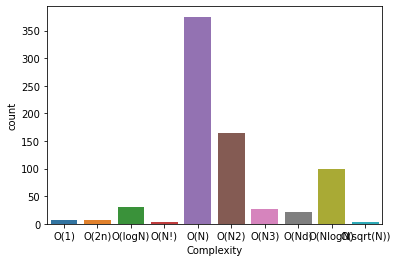

In [ ]:
# Barchart for complexity labels
sns.countplot(df['Complexity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


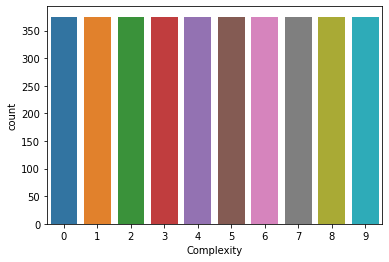

In [ ]:
# Barchart for complexity labels after resampling
sns.countplot(df_upsampled['Complexity'])

# Changing data shape from 2d to 3d

In [ ]:
X.shape

(3750, 128)

In [ ]:
Y.shape

(3750,)

In [ ]:
X_train.shape

(2812, 128)

In [ ]:
Y_train.shape

(2812,)

In [ ]:
X_test.shape

(938, 128)

In [ ]:
Y_test.shape

(938,)

In [ ]:
# Reshaping to 3d data
X = np.reshape(X,(3750,128,1))
X_train = np.reshape(X_train,(2812, 128,1))
X_test = np.reshape(X_test,(938,128,1))

# BiLSTM with 64 memory units

In [ ]:
def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True),
                                input_shape=(128, 1))) # 64 as input shape is 128; forward + backward = 128
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = BiLSTM()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128, 128)         33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model.fit(X_train, Y_train, epochs=25)

Epoch 1/25
88/88 [==============================] - 28s 229ms/step - loss: 1.8916 - accuracy: 0.3215
Epoch 2/25
88/88 [==============================] - 22s 249ms/step - loss: 1.2752 - accuracy: 0.5455
Epoch 3/25
88/88 [==============================] - 20s 227ms/step - loss: 1.0119 - accuracy: 0.6440
Epoch 4/25
88/88 [==============================] - 22s 249ms/step - loss: 0.8016 - accuracy: 0.7191
Epoch 5/25
88/88 [==============================] - 20s 226ms/step - loss: 0.7326 - accuracy: 0.7393
Epoch 6/25
88/88 [==============================] - 22s 250ms/step - loss: 0.7267 - accuracy: 0.7500
Epoch 7/25
88/88 [==============================] - 22s 249ms/step - loss: 0.6382 - accuracy: 0.7660
Epoch 8/25
88/88 [==============================] - 20s 227ms/step - loss: 0.5577 - accuracy: 0.8126
Epoch 9/25
88/88 [==============================] - 22s 248ms/step - loss: 0.5255 - accuracy: 0.8176
Epoch 10/25
88/88 [==============================] - 20s 225ms/step - loss: 0.5463 - accura

In [ ]:
# save the model to disk
#filename = 'finalized_model1.sav'
#pickle.dump(model, open(filename, 'wb'))
#joblib.dump(model, filename)

['finalized_model1.sav']

In [ ]:
model.save('finalized_model1.sav', save_format="h5")

In [ ]:
table_df = pd.DataFrame(history1.history)
table_df.index += 1
print(table_df)

        loss  accuracy
1   1.891557  0.321479
2   1.275160  0.545519
3   1.011934  0.644026
4   0.801617  0.719061
5   0.732612  0.739331
6   0.726662  0.750000
7   0.638183  0.766003
8   0.557675  0.812589
9   0.525459  0.817568
10  0.546259  0.806543
11  0.460694  0.840327
12  0.438665  0.849573
13  0.371021  0.878378
14  0.400094  0.862731
15  0.557679  0.815789
16  0.714697  0.757824
17  0.403498  0.867710
18  0.358377  0.879801
19  0.286442  0.910028
20  0.396356  0.870910
21  0.294767  0.900782
22  0.245603  0.926031
23  0.318454  0.900782
24  0.277181  0.910740
25  0.253546  0.917141


In [ ]:
table_df2 = table_df[table_df.index % 5 == 0]
table_df2

,loss,accuracy
5,0.732612,0.739331
10,0.546259,0.806543
15,0.557679,0.815789
20,0.396356,0.870910
25,0.253546,0.917141


In [ ]:
table_df.to_csv('data1.csv')
files.download("data1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
table_df2.to_csv('data1_1.csv')
files.download("data1_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

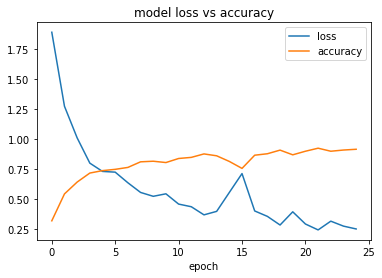

In [ ]:
pyplot.plot(history1.history['loss'])
pyplot.plot(history1.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

30/30 - 3s - loss: 0.3099 - accuracy: 0.9062 - 3s/epoch - 108ms/step

Test accuracy: 0.9061833620071411


In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=False)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
test_results

[0.3098714351654053, 0.9061833620071411]

# Method 2 (Resampling by combining "x" variable with language)

In [ ]:
# Loading dataset
x,y = load_dataset_files(labels_file,embeddings_file)

In [ ]:
def resample_data(df,temp):
    df_majority = df[(df['Complexity'] == 'O(N)')]
    df_minority_1 = df[(df['Complexity'] == 'O(N2)')]
    df_minority_2 = df[(df['Complexity'] == 'O(NlogN)')]
    df_minority_3 = df[(df['Complexity'] == 'O(logN)')]
    df_minority_4 = df[(df['Complexity'] == 'O(N3)')]
    df_minority_5 = df[(df['Complexity'] == 'O(Nd)')]
    minority = [df_minority_1, df_minority_2, df_minority_3, df_minority_4, df_minority_5]
    for i in minority:
        df_minority_upsampled = resample(i,replace=True,n_samples= len(df_majority),random_state=42)  
        temp.append(df_minority_upsampled)
    df_upsampled = df_majority
    for k in temp:
        df_upsampled = pd.concat([k, df_upsampled])
    return df_upsampled

In [ ]:
def method2(x,y,labels_file):
    # Creating Dataframes
    df = pd.DataFrame(x,columns=[("emb"+str(num)) for num in range(1,129)]) # Dataframe to get all embeddings program wise
    df_y = pd.read_csv(labels_file, sep = " ", header=None, names=["Complexity", "Node Number", "Language"])
    df['Complexity'] = df_y['Complexity'] # Adding y label to each corresponding program's embeddings
    df['Language']=df_y['Language'] # Adding Language to each corresponding program's embeddings

    df.reset_index()

    ind=df.set_index('Complexity')
    df = ind.drop(["O(1)", "O(2n)", "O(N!)","O(sqrt(N))"])

    df=df.reset_index()

    #print(df.index)

    #print("Before")
    #df['Language'].value_counts()

    for i in df.index:
      if df['Language'][i]=='C':
          df['Language'][i]=1
      elif df['Language'][i]=='Python':
          df['Language'][i]=2
      else:
          df['Language'][i]=3

    #print("C")
    #df[df['Language']==1]['Complexity'].value_counts()
    #print("Python")
    #df[df['Language']==2]['Complexity'].value_counts()
    #print("Java")
    #df[df['Language']==3]['Complexity'].value_counts()

    df_c=df[df['Language']==1]
    df_python=df[df['Language']==2]
    df_java=df[df['Language']==3]

    df_java=df_java.reset_index()
    df_c=df_c.reset_index()
    df_python=df_python.reset_index()

    df_java.shape, df_c.shape, df_python.shape


    # Resampling - Oversampling 

    t1=[]
    t2=[]
    t3=[]
    df1=resample_data(df_c,t1)
    df2=resample_data(df_python,t2)
    df3=resample_data(df_java,t3)

    df1['Complexity'].value_counts()
    df2['Complexity'].value_counts()
    df3['Complexity'].value_counts()

    frames=[df1,df2,df3]
    df_upsampled=pd.concat(frames)
    df_upsampled=df_upsampled.reset_index()
    df_upsampled=df_upsampled.drop(labels=["level_0","index"],axis=1)
    df_upsampled
    #df_upsampled['Complexity'].value_counts()

    sns.countplot(df_upsampled['Complexity'])

    df_new = df_upsampled
    # df = oversampled
    factor = pd.factorize(df_new['Complexity'])
    df_new.Complexity= factor[0]
    definitions = factor[1]
    print(df_new.Complexity.head())
    print(definitions)

    #Splitting the data into independent and dependent variables
    X = df_new.iloc[:,1:130].values

    Y = df_new['Complexity']

    le = LabelEncoder()
    Y = le.fit_transform(Y)

    # Creating the Training and Test set from data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 21)

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return df, df_y, df1, df2, df3, df_upsampled, df_new, X, Y, X_train, X_test, Y_train, Y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as 

0    0
1    0
2    0
3    0
4    0
Name: Complexity, dtype: int64
Index(['O(Nd)', 'O(N3)', 'O(logN)', 'O(NlogN)', 'O(N2)', 'O(N)'], dtype='object')


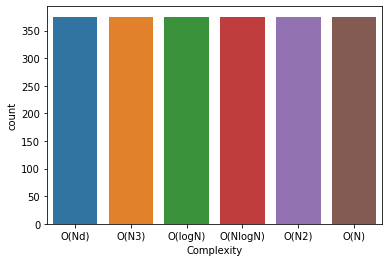

In [ ]:
df, df_y, df1, df2, df3, df_upsampled, df_new, X, Y, X_train, X_test, Y_train, Y_test = method2(x,y,labels_file)

# Changing data shape from 2d to 3d

In [ ]:
X.shape

(2250, 129)

In [ ]:
Y.shape

(2250,)

In [ ]:
X_train.shape

(1687, 129)

In [ ]:
Y_train.shape

(1687,)

In [ ]:
X_test.shape

(563, 129)

In [ ]:
Y_test.shape

(563,)

In [ ]:
# Reshaping to 3d data
#X = np.reshape(X,(2970,128,1))
X_train = np.reshape(X_train,(1687, 129,1))
X_test = np.reshape(X_test,(563,129,1))

# BiLSTM with 65 memory units

In [ ]:
def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(65, return_sequences=True),
                                input_shape=(129, 1))) # 64 as input shape is 128; forward + backward = 128
    model.add(Bidirectional(LSTM(65)))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = BiLSTM()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 129, 130)         34840     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 130)              101920    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 786       
                                                                 
Total params: 137,546
Trainable params: 137,546
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model.fit(X_train, Y_train, epochs=50)

Epoch 1/50
53/53 [==============================] - 21s 246ms/step - loss: 1.6025 - accuracy: 0.3154
Epoch 2/50
53/53 [==============================] - 15s 282ms/step - loss: 1.4275 - accuracy: 0.3954
Epoch 3/50
53/53 [==============================] - 13s 246ms/step - loss: 1.3392 - accuracy: 0.4416
Epoch 4/50
53/53 [==============================] - 13s 244ms/step - loss: 1.2363 - accuracy: 0.5080
Epoch 5/50
53/53 [==============================] - 13s 246ms/step - loss: 1.1124 - accuracy: 0.5531
Epoch 6/50
53/53 [==============================] - 17s 318ms/step - loss: 1.0219 - accuracy: 0.6088
Epoch 7/50
53/53 [==============================] - 13s 245ms/step - loss: 0.9748 - accuracy: 0.6266
Epoch 8/50
53/53 [==============================] - 13s 244ms/step - loss: 0.8396 - accuracy: 0.7072
Epoch 9/50
53/53 [==============================] - 15s 282ms/step - loss: 0.7932 - accuracy: 0.7178
Epoch 10/50
53/53 [==============================] - 15s 283ms/step - loss: 0.7403 - accura

In [ ]:
# save the model to disk
#filename = 'finalized_model2.sav'
#pickle.dump(model, open(filename, 'wb'))
#joblib.dump(model, filename)

In [ ]:
model.save('finalized_model2.sav', save_format="h5")

In [ ]:
table_df = pd.DataFrame(history2.history)
table_df.index += 1
print(table_df)

        loss  accuracy
1   1.602520  0.315353
2   1.427496  0.395376
3   1.339150  0.441612
4   1.236322  0.508002
5   1.112352  0.553053
6   1.021855  0.608773
7   0.974811  0.626556
8   0.839591  0.707173
9   0.793157  0.717842
10  0.740306  0.733254
11  0.681075  0.758151
12  0.683792  0.747481
13  0.581703  0.805572
14  0.565189  0.806758
15  0.505309  0.829283
16  0.484694  0.838767
17  0.495573  0.838174
18  0.418128  0.867220
19  0.377238  0.885596
20  0.350874  0.888560
21  0.371144  0.883817
22  0.586555  0.793124
23  0.401190  0.869591
24  0.324727  0.898044
25  0.272645  0.912863
26  0.389319  0.868405
27  0.556766  0.809129
28  0.311276  0.906935
29  0.289941  0.909306
30  0.286604  0.909899
31  0.232192  0.924718
32  0.195709  0.941316
33  0.196508  0.942501
34  0.179987  0.940130
35  0.202429  0.936574
36  0.234138  0.925311
37  0.232368  0.924126
38  0.339587  0.887374
39  0.187171  0.943687
40  0.127638  0.963841
41  0.132290  0.965027
42  0.141384  0.956728
43  0.14253

In [ ]:
table_df2 = table_df[table_df.index % 10 == 0]
table_df2

,loss,accuracy
10,0.740306,0.733254
20,0.350874,0.888560
30,0.286604,0.909899
40,0.127638,0.963841
50,0.178953,0.944873


In [ ]:
table_df.to_csv('data2.csv')
files.download("data2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
table_df2.to_csv('data2_1.csv')
files.download("data2_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

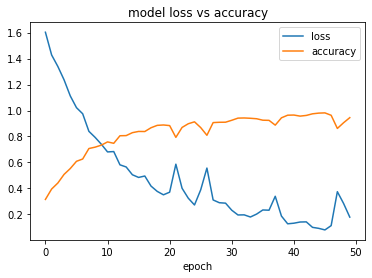

In [ ]:
pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

18/18 - 3s - loss: 0.3940 - accuracy: 0.8881 - 3s/epoch - 155ms/step

Test accuracy: 0.8880994915962219


In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=False)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
test_results

[0.394044429063797, 0.8880994915962219]

# BiLSTM with 129 memory units

In [ ]:
def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(129, return_sequences=True),
                                input_shape=(129, 1))) # 64 as input shape is 128; forward + backward = 128
    model.add(Bidirectional(LSTM(129)))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = BiLSTM()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 129, 258)         135192    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 258)              400416    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 1554      
                                                                 
Total params: 537,162
Trainable params: 537,162
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2_1 = model.fit(X_train, Y_train, epochs=50)

Epoch 1/50
53/53 [==============================] - 53s 857ms/step - loss: 1.5662 - accuracy: 0.3438
Epoch 2/50
53/53 [==============================] - 46s 863ms/step - loss: 1.3761 - accuracy: 0.4185
Epoch 3/50
53/53 [==============================] - 45s 858ms/step - loss: 1.2484 - accuracy: 0.4861
Epoch 4/50
53/53 [==============================] - 46s 862ms/step - loss: 1.2510 - accuracy: 0.4861
Epoch 5/50
53/53 [==============================] - 46s 868ms/step - loss: 1.0353 - accuracy: 0.5791
Epoch 6/50
53/53 [==============================] - 46s 865ms/step - loss: 0.9704 - accuracy: 0.6117
Epoch 7/50
53/53 [==============================] - 45s 848ms/step - loss: 0.8658 - accuracy: 0.6680
Epoch 8/50
53/53 [==============================] - 45s 849ms/step - loss: 0.7427 - accuracy: 0.7309
Epoch 9/50
53/53 [==============================] - 47s 884ms/step - loss: 0.7242 - accuracy: 0.7368
Epoch 10/50
53/53 [==============================] - 43s 814ms/step - loss: 0.6461 - accura

In [ ]:
# save the model to disk
#filename = 'finalized_model2_1.sav'
#pickle.dump(model, open(filename, 'wb'))
#joblib.dump(model, filename)

In [ ]:
model.save('finalized_model2_1.sav', save_format="h5")

In [ ]:
table_df = pd.DataFrame(history2_1.history)
table_df.index += 1
print(table_df)

        loss  accuracy
1   1.566166  0.343806
2   1.376114  0.418494
3   1.248435  0.486070
4   1.251033  0.486070
5   1.035308  0.579135
6   0.970448  0.611737
7   0.865808  0.668050
8   0.742681  0.730883
9   0.724209  0.736811
10  0.646116  0.763485
11  0.505703  0.820984
12  0.496300  0.832247
13  0.499257  0.825726
14  0.480268  0.834025
15  0.350702  0.883225
16  0.348664  0.876111
17  0.392065  0.865442
18  0.301355  0.898637
19  0.273253  0.912270
20  0.479728  0.822762
21  0.417719  0.856550
22  0.229438  0.928868
23  0.174985  0.948429
24  0.241671  0.918791
25  0.219709  0.922940
26  0.200208  0.936574
27  0.179485  0.940723
28  0.154553  0.954357
29  0.112835  0.965027
30  0.150402  0.951986
31  0.281812  0.910492
32  0.236279  0.918198
33  0.129424  0.960285
34  0.115896  0.967398
35  0.114700  0.968583
36  0.087955  0.975697
37  0.207700  0.937167
38  0.113788  0.967398
39  0.084667  0.976289
40  0.082642  0.978660
41  0.047045  0.990516
42  0.101969  0.970362
43  0.19795

In [ ]:
table_df2 = table_df[table_df.index % 10 == 0]
table_df2

,loss,accuracy
10,0.646116,0.763485
20,0.479728,0.822762
30,0.150402,0.951986
40,0.082642,0.978660
50,0.151094,0.953171


In [ ]:
table_df.to_csv('data3.csv')
files.download("data3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
table_df.to_csv('data3_1.csv')
files.download("data3_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

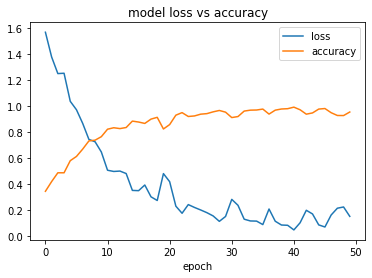

In [ ]:
pyplot.plot(history2_1.history['loss'])
pyplot.plot(history2_1.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

18/18 - 6s - loss: 0.3813 - accuracy: 0.9112 - 6s/epoch - 348ms/step

Test accuracy: 0.9111900329589844


In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=False)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
test_results

[0.3812532424926758, 0.9111900329589844]

# Method 3 (Resampling by combining "y" complexity label with language)

In [ ]:
# Loading dataset
x,y = load_dataset_files(labels_file,embeddings_file)

In [ ]:
def method3(x,y,labels_file):
    # Creating Dataframes
    df = pd.DataFrame(x,columns=[("emb"+str(num)) for num in range(1,129)]) # Dataframe to get all embeddings program wise
    df_y = pd.read_csv(labels_file, sep = " ", header=None, names=["Complexity", "Node Number", "Language"])
    df['Complexity'] = df_y['Complexity'] # Adding y label to each corresponding program's embeddings
    df['Language']=df_y['Language']

    df.reset_index()

    ind=df.set_index('Complexity')
    df = ind.drop(["O(1)", "O(2n)", "O(N!)","O(sqrt(N))"])

    df=df.reset_index()

    df['Target'] = df['Language']+'_'+ df['Complexity']

    # Resampling - Oversampling 

    mapping=dict()
    labels = list(df['Target'].unique())
    for i in range(len(labels)):
      mapping[labels[i]]=i

    df['mapping']=df['Target'].replace(mapping)

    X, Y = df.iloc[:, 1:129], df['mapping']

    # transform the dataset
    oversample = SMOTE(k_neighbors=2)
    X, Y = oversample.fit_resample(X, Y)

    # summarize distribution
    counter = Counter(Y)
    for k,v in counter.items():
      per = v / len(Y) * 100
      print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

    # Creating the Training and Test set from data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 21)

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return df, df_y, X, Y, X_train, X_test, Y_train, Y_test

Class=0, n=165 (5.556%)
Class=1, n=165 (5.556%)
Class=2, n=165 (5.556%)
Class=3, n=165 (5.556%)
Class=4, n=165 (5.556%)
Class=5, n=165 (5.556%)
Class=6, n=165 (5.556%)
Class=7, n=165 (5.556%)
Class=8, n=165 (5.556%)
Class=9, n=165 (5.556%)
Class=10, n=165 (5.556%)
Class=11, n=165 (5.556%)
Class=12, n=165 (5.556%)
Class=13, n=165 (5.556%)
Class=14, n=165 (5.556%)
Class=15, n=165 (5.556%)
Class=16, n=165 (5.556%)
Class=17, n=165 (5.556%)


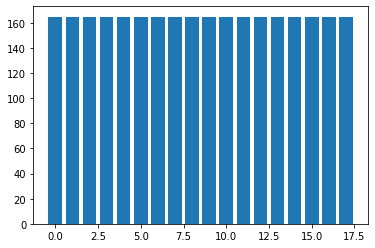

In [ ]:
df, df_y, X, Y, X_train, X_test, Y_train, Y_test = method3(x,y,labels_file)

# Changing data shape from 2d to 3d

In [ ]:
X.shape

(2970, 128)

In [ ]:
Y.shape

(2970,)

In [ ]:
X_train.shape

(2227, 128)

In [ ]:
Y_train.shape

(2227,)

In [ ]:
X_test.shape

(743, 128)

In [ ]:
Y_test.shape

(743,)

In [ ]:
# Reshaping to 3d data
#X = np.reshape(X,(2970,128,1))
X_train = np.reshape(X_train,(2227, 128,1))
X_test = np.reshape(X_test,(743,128,1))

# BiLSTM with 64 memory units

In [ ]:
def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True),
                                input_shape=(128, 1))) # 64 as input shape is 128; forward + backward = 128
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(18, activation="softmax"))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = BiLSTM()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 128, 128)         33792     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 18)                2322      
                                                                 
Total params: 134,930
Trainable params: 134,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = model.fit(X_train, Y_train, epochs=50)

Epoch 1/50
70/70 [==============================] - 26s 253ms/step - loss: 2.1731 - accuracy: 0.2690
Epoch 2/50
70/70 [==============================] - 16s 229ms/step - loss: 1.4161 - accuracy: 0.4737
Epoch 3/50
70/70 [==============================] - 16s 228ms/step - loss: 1.2287 - accuracy: 0.5366
Epoch 4/50
70/70 [==============================] - 16s 227ms/step - loss: 1.1280 - accuracy: 0.5658
Epoch 5/50
70/70 [==============================] - 18s 255ms/step - loss: 1.0421 - accuracy: 0.6260
Epoch 6/50
70/70 [==============================] - 16s 231ms/step - loss: 0.9424 - accuracy: 0.6601
Epoch 7/50
70/70 [==============================] - 16s 228ms/step - loss: 0.8693 - accuracy: 0.6821
Epoch 8/50
70/70 [==============================] - 18s 254ms/step - loss: 0.8755 - accuracy: 0.6668
Epoch 9/50
70/70 [==============================] - 16s 228ms/step - loss: 0.8111 - accuracy: 0.6982
Epoch 10/50
70/70 [==============================] - 16s 228ms/step - loss: 0.8161 - accura

In [ ]:
# save the model to disk
#filename = 'finalized_model3.sav'
#pickle.dump(model, open(filename, 'wb'))
#joblib.dump(model, filename)

In [ ]:
model.save('finalized_model3.sav', save_format="h5")

In [ ]:
table_df = pd.DataFrame(history3.history)
table_df.index += 1
print(table_df)

        loss  accuracy
1   2.173141  0.268972
2   1.416103  0.473731
3   1.228738  0.536596
4   1.127975  0.565784
5   1.042105  0.625954
6   0.942413  0.660081
7   0.869284  0.682084
8   0.875474  0.666816
9   0.811100  0.698249
10  0.816114  0.698698
11  0.767766  0.719802
12  0.673753  0.750786
13  0.657617  0.757521
14  0.623120  0.775932
15  0.623272  0.782667
16  0.567309  0.806466
17  0.527886  0.817692
18  0.511012  0.821284
19  0.544955  0.805568
20  0.509975  0.828918
21  0.523700  0.827122
22  0.442047  0.850471
23  0.467459  0.851819
24  0.463353  0.846430
25  0.439700  0.846879
26  0.392211  0.867984
27  0.487896  0.827571
28  0.450428  0.843287
29  0.370969  0.873821
30  0.338154  0.889987
31  0.306040  0.905703
32  0.439472  0.845532
33  0.365985  0.878761
34  0.321090  0.897171
35  0.374089  0.867535
36  0.267231  0.914683
37  0.233942  0.931298
38  0.246615  0.928154
39  0.201604  0.943422
40  0.226565  0.933992
41  0.268568  0.915582
42  0.276587  0.905703
43  0.25356

In [ ]:
table_df2 = table_df[table_df.index % 10 == 0]
table_df2

,loss,accuracy
10,0.816114,0.698698
20,0.509975,0.828918
30,0.338154,0.889987
40,0.226565,0.933992
50,0.145003,0.956893


In [ ]:
table_df.to_csv('data4.csv')
files.download("data4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
table_df.to_csv('data4_1.csv')
files.download("data4_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

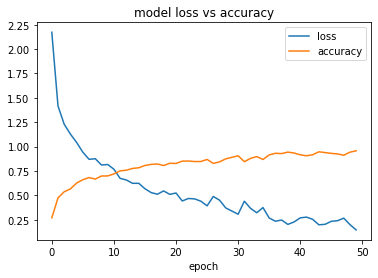

In [ ]:
pyplot.plot(history3.history['loss'])
pyplot.plot(history3.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

24/24 - 3s - loss: 0.3086 - accuracy: 0.9098 - 3s/epoch - 125ms/step

Test accuracy: 0.9098250269889832


In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=False)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
test_results

[0.30856508016586304, 0.9098250269889832]

# BiLSTM with 128 memory units

In [ ]:
def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True),
                                input_shape=(128, 1))) # 64 as input shape is 128; forward + backward = 128
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(18, activation="softmax"))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = BiLSTM()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 128, 256)         133120    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 18)                4626      
                                                                 
Total params: 531,986
Trainable params: 531,986
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3_1 = model.fit(X_train, Y_train, epochs=50)

Epoch 1/50
70/70 [==============================] - 63s 778ms/step - loss: 1.9069 - accuracy: 0.3260
Epoch 2/50
70/70 [==============================] - 54s 772ms/step - loss: 1.3242 - accuracy: 0.4814
Epoch 3/50
70/70 [==============================] - 55s 781ms/step - loss: 1.1739 - accuracy: 0.5402
Epoch 4/50
70/70 [==============================] - 54s 771ms/step - loss: 1.0547 - accuracy: 0.5932
Epoch 5/50
70/70 [==============================] - 56s 805ms/step - loss: 0.9670 - accuracy: 0.6318
Epoch 6/50
70/70 [==============================] - 54s 779ms/step - loss: 0.8714 - accuracy: 0.6807
Epoch 7/50
70/70 [==============================] - 54s 779ms/step - loss: 0.8383 - accuracy: 0.6897
Epoch 8/50
70/70 [==============================] - 54s 775ms/step - loss: 0.7698 - accuracy: 0.7274
Epoch 9/50
70/70 [==============================] - 57s 807ms/step - loss: 0.6940 - accuracy: 0.7526
Epoch 10/50
70/70 [==============================] - 54s 772ms/step - loss: 0.6740 - accura

In [ ]:
# save the model to disk
#filename = 'finalized_model3_1.sav'
#pickle.dump(model, open(filename, 'wb'))
#joblib.dump(model, filename)

In [ ]:
model.save('finalized_model3_1.sav', save_format="h5")

In [ ]:
table_df = pd.DataFrame(history3_1.history)
table_df.index += 1
print(table_df)

        loss  accuracy
1   1.906946  0.325999
2   1.324170  0.481365
3   1.173899  0.540189
4   1.054727  0.593175
5   0.967043  0.631792
6   0.871353  0.680736
7   0.838347  0.689717
8   0.769825  0.727436
9   0.693962  0.752582
10  0.673989  0.751684
11  0.625777  0.777279
12  0.586967  0.793893
13  0.593978  0.787607
14  0.535945  0.811405
15  0.509194  0.822182
16  0.506043  0.835204
17  0.430805  0.858105
18  0.371329  0.874270
19  0.358181  0.879659
20  0.413992  0.849124
21  0.361156  0.883251
22  0.318284  0.893130
23  0.321488  0.895824
24  0.245143  0.927705
25  0.278970  0.905703
26  0.245416  0.921419
27  0.222615  0.935339
28  0.272137  0.911091
29  0.258663  0.917378
30  0.199777  0.938033
31  0.210231  0.929951
32  0.225171  0.929951
33  0.235851  0.926807
34  0.156602  0.954647
35  0.166204  0.952851
36  0.115306  0.969017
37  0.109170  0.970364
38  0.102513  0.972609
39  0.083592  0.978895
40  0.118924  0.965424
41  0.110912  0.967220
42  0.223609  0.931298
43  0.10761

In [ ]:
table_df2 = table_df[table_df.index % 10 == 0]
table_df2

,loss,accuracy
10,0.673989,0.751684
20,0.413992,0.849124
30,0.199777,0.938033
40,0.118924,0.965424
50,0.068974,0.981590


In [ ]:
table_df.to_csv('data5.csv')
files.download("data5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
table_df.to_csv('data5_1.csv')
files.download("data5_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

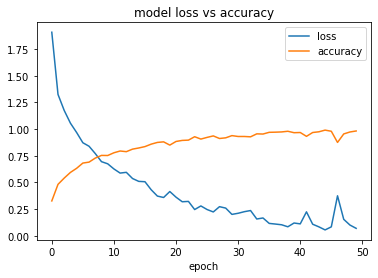

In [ ]:
pyplot.plot(history3_1.history['loss'])
pyplot.plot(history3_1.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

24/24 - 7s - loss: 0.2685 - accuracy: 0.9287 - 7s/epoch - 286ms/step

Test accuracy: 0.9286675453186035


In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=False)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
test_results

[0.2684553861618042, 0.9286675453186035]

# Method 1 with 6 labels instead of 10

In [ ]:
def method4(x,y,labels_file):
    # Creating Dataframes
    df = pd.DataFrame(x,columns=[("emb"+str(num)) for num in range(1,129)]) # Dataframe to get all embeddings program wise
    df_y = pd.read_csv(labels_file, sep = " ", header=None, names=["Complexity", "Node Number", "Language"])
    df['Complexity'] = df_y['Complexity'] # Adding y label to each corresponding program's embeddings
    #df['Language']=df_y['Language']

    df.drop(df[df['Complexity'] == "O(1)"].index, inplace = True)
    df.drop(df[df['Complexity'] == "O(2n)"].index, inplace = True)
    df.drop(df[df['Complexity'] == "O(N!)"].index, inplace = True)
    df.drop(df[df['Complexity'] == "O(sqrt(N))"].index, inplace = True)

    df = df.reset_index()

    df.drop(['index'], axis=1)

    #df.drop(['index', 'Language'], axis=1)

    # Resampling - Oversampling 

    #create two different dataframe of majority and minority class 
    df_majority = df[(df['Complexity'] == 'O(N)')] 
    df_minority_1 = df[(df['Complexity'] == 'O(N2)')] 
    df_minority_2 = df[(df['Complexity'] == 'O(NlogN)')] 
    df_minority_3 = df[(df['Complexity'] == 'O(logN)')] 
    df_minority_4 = df[(df['Complexity'] == 'O(N3)')]
    df_minority_5 = df[(df['Complexity'] == 'O(Nd)')]
    #df_minority_6 = df[(df['Complexity'] == 'O(2n)')]
    #df_minority_7 = df[(df['Complexity'] == 'O(1)')]
    #df_minority_8 = df[(df['Complexity'] == 'O(N!)')]
    #df_minority_9 = df[(df['Complexity'] == 'O(sqrt(N))')]

    # upsample minority class
    minority = [df_minority_1, df_minority_2, df_minority_3, df_minority_4, df_minority_5]
    #minority = [df_minority_1, df_minority_2, df_minority_3, df_minority_4, df_minority_5, df_minority_6, df_minority_7, df_minority_8, df_minority_9]
    temp = []
    for i in minority:
      df_minority_upsampled = resample(i, 
                                      replace=True,    # sample with replacement
                                      n_samples= 375, # to match majority class
                                      random_state=42)  # reproducible results
      temp.append(df_minority_upsampled)
    # Combine majority class with upsampled minority class
    df_upsampled = df_majority
    for i in temp:
      df_upsampled = pd.concat([i, df_upsampled])

    new_df = df_upsampled
    # df = oversampled
    factor = pd.factorize(new_df['Complexity'])
    new_df.Complexity= factor[0]
    definitions = factor[1]
    #print(new_df.Complexity.head())
    print(definitions)

    #Splitting the data into independent and dependent variables
    X = new_df.iloc[:,0:128].values
    Y = new_df.iloc[:,128].values
    #print('The independent features set: ')
    #print(X[:5,:])
    #print('The dependent variable: ')
    #print(Y[:5])

    Y = new_df['Complexity']

    le = LabelEncoder()
    Y = le.fit_transform(Y)

    # Creating the Training and Test set from data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 21)

    # Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return df, df_y, df_upsampled, new_df, X, Y, X_train, X_test, Y_train, Y_test

In [ ]:
df, df_y, df_upsampled, new_df, X, Y, X_train, X_test, Y_train, Y_test = method4(x,y,labels_file)

Index(['O(Nd)', 'O(N3)', 'O(logN)', 'O(NlogN)', 'O(N2)', 'O(N)'], dtype='object')


# Checking count of programs before and after Resampling

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


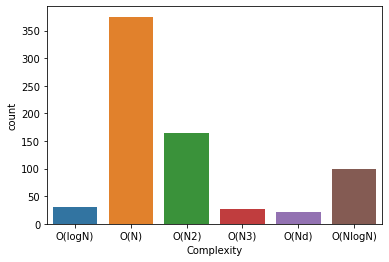

In [ ]:
# Barchart for complexity labels
sns.countplot(df['Complexity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


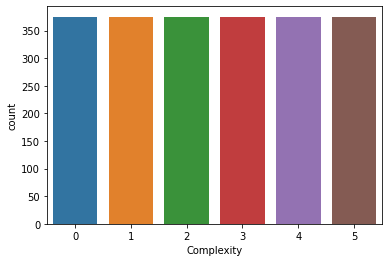

In [ ]:
# Barchart for complexity labels after resampling
sns.countplot(df_upsampled['Complexity'])

# Changing data shape from 2d to 3d

In [ ]:
X.shape

(2250, 128)

In [ ]:
Y.shape

(2250,)

In [ ]:
X_train.shape

(1687, 128)

In [ ]:
Y_train.shape

(1687,)

In [ ]:
X_test.shape

(563, 128)

In [ ]:
Y_test.shape

(563,)

In [ ]:
# Reshaping to 3d data
X = np.reshape(X,(2250,128,1))
X_train = np.reshape(X_train,(1687, 128,1))
X_test = np.reshape(X_test,(563,128,1))

# BiLSTM with 64 memory units

In [ ]:
def BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True),
                                input_shape=(128, 1))) # 64 as input shape is 128; forward + backward = 128
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = BiLSTM()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 128, 128)         33792     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
Total params: 133,382
Trainable params: 133,382
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history4 = model.fit(X_train, Y_train, epochs=25)

Epoch 1/25
53/53 [==============================] - 22s 264ms/step - loss: 1.5994 - accuracy: 0.3183
Epoch 2/25
53/53 [==============================] - 14s 269ms/step - loss: 1.3741 - accuracy: 0.4440
Epoch 3/25
53/53 [==============================] - 13s 239ms/step - loss: 1.1985 - accuracy: 0.5287
Epoch 4/25
53/53 [==============================] - 13s 237ms/step - loss: 1.0660 - accuracy: 0.5815
Epoch 5/25
53/53 [==============================] - 13s 237ms/step - loss: 0.9471 - accuracy: 0.6271
Epoch 6/25
53/53 [==============================] - 13s 238ms/step - loss: 0.8501 - accuracy: 0.6823
Epoch 7/25
53/53 [==============================] - 15s 274ms/step - loss: 0.7642 - accuracy: 0.7321
Epoch 8/25
53/53 [==============================] - 13s 236ms/step - loss: 0.6617 - accuracy: 0.7765
Epoch 9/25
53/53 [==============================] - 17s 324ms/step - loss: 0.5928 - accuracy: 0.7973
Epoch 10/25
53/53 [==============================] - 16s 306ms/step - loss: 0.5052 - accura

In [ ]:
model.save('finalized_model4.sav', save_format="h5")

In [ ]:
table_df = pd.DataFrame(history4.history)
table_df.index += 1
print(table_df)

        loss  accuracy
1   1.599410  0.318317
2   1.374084  0.443983
3   1.198508  0.528749
4   1.066018  0.581506
5   0.947064  0.627149
6   0.850083  0.682276
7   0.764191  0.732069
8   0.661683  0.776526
9   0.592835  0.797273
10  0.505248  0.838767
11  0.564516  0.808536
12  0.515005  0.825133
13  0.380446  0.887374
14  0.341353  0.896266
15  0.300243  0.912863
16  0.408342  0.870777
17  0.283557  0.915234
18  0.256065  0.924718
19  0.201962  0.946058
20  0.206412  0.943687
21  0.215645  0.939538
22  0.182047  0.953171
23  0.145824  0.963248
24  0.155188  0.959099
25  0.175885  0.955542


In [ ]:
table_df2 = table_df[table_df.index % 5 == 0]
table_df2

,loss,accuracy
5,0.947064,0.627149
10,0.505248,0.838767
15,0.300243,0.912863
20,0.206412,0.943687
25,0.175885,0.955542


In [ ]:
table_df.to_csv('data6.csv')
files.download("data6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
table_df2.to_csv('data6_1.csv')
files.download("data6_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

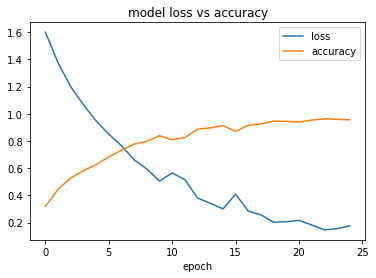

In [ ]:
pyplot.plot(history4.history['loss'])
pyplot.plot(history4.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

18/18 - 3s - loss: 0.3376 - accuracy: 0.8934 - 3s/epoch - 156ms/step

Test accuracy: 0.8934280872344971


In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=False)
#print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
test_results

[0.33758318424224854, 0.8934280872344971]

# -- End of Notebook --

In [ ]:
x,y = load_dataset_files(labels_file,embeddings_file)

In [ ]:
df = pd.DataFrame(x,columns=[("emb"+str(num)) for num in range(1,129)]) # Dataframe to get all embeddings program wise
df

,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,...,emb119,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127,emb128
0,-0.054682,0.127175,0.036648,0.090353,0.192498,0.043540,-0.060334,-0.037632,-0.001838,0.116995,...,-0.125052,-0.049275,-0.131080,0.002272,-0.017875,-0.209266,0.199226,0.097312,-0.107657,0.081840
1,-0.095235,0.175034,0.063935,0.117448,0.255929,0.064811,-0.072923,-0.032716,0.013575,0.152739,...,-0.191601,-0.024092,-0.185713,-0.016963,-0.040366,-0.277818,0.261729,0.118124,-0.125564,0.130719
2,-0.135813,0.219436,0.102143,0.135153,0.286394,0.068151,-0.078952,-0.003041,0.021949,0.182400,...,-0.259607,0.008541,-0.236532,-0.032249,-0.071049,-0.334604,0.334102,0.128357,-0.144719,0.192227
3,0.270222,0.300358,-0.445603,0.196632,0.531115,0.433794,-0.261992,-0.074271,-0.215854,-0.061681,...,-0.392645,-0.586666,-0.216605,-0.092687,-0.081682,-0.599847,0.550452,0.468392,-0.247837,0.087675
4,0.102710,0.177498,-0.326135,0.302662,0.256015,0.207272,-0.175998,-0.057321,0.000238,0.019773,...,-0.449514,-0.386576,-0.253997,-0.026445,-0.061492,-0.581163,0.442037,0.418021,-0.194271,0.098900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.162677,-0.179751,-0.320467,0.374476,0.487395,-0.065953,-0.380204,-0.143154,-0.065873,0.257494,...,-0.329598,-0.397525,0.117815,0.099337,-0.094519,-0.544291,0.213452,0.262748,-0.306325,-0.224609
736,0.183020,-0.166014,-0.231057,0.452174,0.562882,-0.138434,-0.443576,-0.284463,-0.054835,0.159889,...,-0.263365,-0.445122,0.000230,0.095979,-0.063981,-0.603873,0.114075,0.222806,-0.317638,-0.290131
737,0.184769,-0.201651,-0.235364,0.446800,0.547860,-0.155865,-0.472018,-0.309393,-0.079808,0.205073,...,-0.239681,-0.489142,-0.006414,0.128634,-0.109084,-0.605826,0.106701,0.230898,-0.321285,-0.266228
738,0.255681,-0.193824,-0.382822,0.447094,0.499922,-0.083941,-0.402473,-0.251599,-0.028515,0.150684,...,-0.323401,-0.498780,0.046986,0.124914,-0.117825,-0.633948,0.106924,0.273179,-0.336416,-0.300430


In [ ]:
df_y = pd.read_csv(labels_file, sep = " ", header=None, names=["Complexity", "Node Number", "Language"])
df_y

,Complexity,Node Number,Language
0,O(1),nodes0,C
1,O(2n),nodes0,C
2,O(2n),nodes1,C
3,O(logN),nodes0,C
4,O(logN),nodes1,C
...,...,...,...
735,O(NlogN),nodes5,Java
736,O(NlogN),nodes6,Java
737,O(NlogN),nodes7,Java
738,O(NlogN),nodes8,Java


In [ ]:
df['Complexity'] = df_y['Complexity'] # Adding y label to each corresponding program's embeddings
#df['Language']=df_y['Language']
df

,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,...,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127,emb128,Complexity
0,-0.054682,0.127175,0.036648,0.090353,0.192498,0.043540,-0.060334,-0.037632,-0.001838,0.116995,...,-0.049275,-0.131080,0.002272,-0.017875,-0.209266,0.199226,0.097312,-0.107657,0.081840,O(1)
1,-0.095235,0.175034,0.063935,0.117448,0.255929,0.064811,-0.072923,-0.032716,0.013575,0.152739,...,-0.024092,-0.185713,-0.016963,-0.040366,-0.277818,0.261729,0.118124,-0.125564,0.130719,O(2n)
2,-0.135813,0.219436,0.102143,0.135153,0.286394,0.068151,-0.078952,-0.003041,0.021949,0.182400,...,0.008541,-0.236532,-0.032249,-0.071049,-0.334604,0.334102,0.128357,-0.144719,0.192227,O(2n)
3,0.270222,0.300358,-0.445603,0.196632,0.531115,0.433794,-0.261992,-0.074271,-0.215854,-0.061681,...,-0.586666,-0.216605,-0.092687,-0.081682,-0.599847,0.550452,0.468392,-0.247837,0.087675,O(logN)
4,0.102710,0.177498,-0.326135,0.302662,0.256015,0.207272,-0.175998,-0.057321,0.000238,0.019773,...,-0.386576,-0.253997,-0.026445,-0.061492,-0.581163,0.442037,0.418021,-0.194271,0.098900,O(logN)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.162677,-0.179751,-0.320467,0.374476,0.487395,-0.065953,-0.380204,-0.143154,-0.065873,0.257494,...,-0.397525,0.117815,0.099337,-0.094519,-0.544291,0.213452,0.262748,-0.306325,-0.224609,O(NlogN)
736,0.183020,-0.166014,-0.231057,0.452174,0.562882,-0.138434,-0.443576,-0.284463,-0.054835,0.159889,...,-0.445122,0.000230,0.095979,-0.063981,-0.603873,0.114075,0.222806,-0.317638,-0.290131,O(NlogN)
737,0.184769,-0.201651,-0.235364,0.446800,0.547860,-0.155865,-0.472018,-0.309393,-0.079808,0.205073,...,-0.489142,-0.006414,0.128634,-0.109084,-0.605826,0.106701,0.230898,-0.321285,-0.266228,O(NlogN)
738,0.255681,-0.193824,-0.382822,0.447094,0.499922,-0.083941,-0.402473,-0.251599,-0.028515,0.150684,...,-0.498780,0.046986,0.124914,-0.117825,-0.633948,0.106924,0.273179,-0.336416,-0.300430,O(NlogN)


In [ ]:
df.drop(df[df['Complexity'] == "O(1)"].index, inplace = True)
df.drop(df[df['Complexity'] == "O(2n)"].index, inplace = True)
df.drop(df[df['Complexity'] == "O(N!)"].index, inplace = True)
df.drop(df[df['Complexity'] == "O(sqrt(N))"].index, inplace = True)
#df2 = df[ (df['Complexity'] == "O(1)") | (df['Complexity'] == "O(2n)") | (df['Complexity'] == "O(N!)") | (df['Complexity'] == "O(sqrt(N))")]

In [ ]:
df

,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,...,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127,emb128,Complexity
3,0.270222,0.300358,-0.445603,0.196632,0.531115,0.433794,-0.261992,-0.074271,-0.215854,-0.061681,...,-0.586666,-0.216605,-0.092687,-0.081682,-0.599847,0.550452,0.468392,-0.247837,0.087675,O(logN)
4,0.102710,0.177498,-0.326135,0.302662,0.256015,0.207272,-0.175998,-0.057321,0.000238,0.019773,...,-0.386576,-0.253997,-0.026445,-0.061492,-0.581163,0.442037,0.418021,-0.194271,0.098900,O(logN)
5,0.099151,0.171953,-0.230760,0.147983,0.240728,0.211076,-0.085177,-0.008800,-0.065532,0.133410,...,-0.348318,-0.186028,-0.086344,-0.106616,-0.450628,0.463381,0.325981,-0.107556,0.129127,O(logN)
6,0.004622,0.254111,0.043829,0.140978,0.663985,0.359904,-0.219945,0.108162,-0.140120,-0.066035,...,-0.262810,-0.185516,-0.029431,-0.201144,-0.293320,0.295109,0.290326,-0.353395,0.164944,O(logN)
7,-0.013093,0.067878,-0.087897,0.155157,0.046141,0.043758,-0.005407,-0.022934,0.036307,0.224565,...,-0.180832,-0.147306,-0.039465,-0.092333,-0.350462,0.329363,0.250614,-0.131446,0.113169,O(logN)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.162677,-0.179751,-0.320467,0.374476,0.487395,-0.065953,-0.380204,-0.143154,-0.065873,0.257494,...,-0.397525,0.117815,0.099337,-0.094519,-0.544291,0.213452,0.262748,-0.306325,-0.224609,O(NlogN)
736,0.183020,-0.166014,-0.231057,0.452174,0.562882,-0.138434,-0.443576,-0.284463,-0.054835,0.159889,...,-0.445122,0.000230,0.095979,-0.063981,-0.603873,0.114075,0.222806,-0.317638,-0.290131,O(NlogN)
737,0.184769,-0.201651,-0.235364,0.446800,0.547860,-0.155865,-0.472018,-0.309393,-0.079808,0.205073,...,-0.489142,-0.006414,0.128634,-0.109084,-0.605826,0.106701,0.230898,-0.321285,-0.266228,O(NlogN)
738,0.255681,-0.193824,-0.382822,0.447094,0.499922,-0.083941,-0.402473,-0.251599,-0.028515,0.150684,...,-0.498780,0.046986,0.124914,-0.117825,-0.633948,0.106924,0.273179,-0.336416,-0.300430,O(NlogN)


In [ ]:
df = df.reset_index()

In [ ]:
df

,index,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,...,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127,emb128,Complexity
0,3,0.270222,0.300358,-0.445603,0.196632,0.531115,0.433794,-0.261992,-0.074271,-0.215854,...,-0.586666,-0.216605,-0.092687,-0.081682,-0.599847,0.550452,0.468392,-0.247837,0.087675,O(logN)
1,4,0.102710,0.177498,-0.326135,0.302662,0.256015,0.207272,-0.175998,-0.057321,0.000238,...,-0.386576,-0.253997,-0.026445,-0.061492,-0.581163,0.442037,0.418021,-0.194271,0.098900,O(logN)
2,5,0.099151,0.171953,-0.230760,0.147983,0.240728,0.211076,-0.085177,-0.008800,-0.065532,...,-0.348318,-0.186028,-0.086344,-0.106616,-0.450628,0.463381,0.325981,-0.107556,0.129127,O(logN)
3,6,0.004622,0.254111,0.043829,0.140978,0.663985,0.359904,-0.219945,0.108162,-0.140120,...,-0.262810,-0.185516,-0.029431,-0.201144,-0.293320,0.295109,0.290326,-0.353395,0.164944,O(logN)
4,7,-0.013093,0.067878,-0.087897,0.155157,0.046141,0.043758,-0.005407,-0.022934,0.036307,...,-0.180832,-0.147306,-0.039465,-0.092333,-0.350462,0.329363,0.250614,-0.131446,0.113169,O(logN)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,735,0.162677,-0.179751,-0.320467,0.374476,0.487395,-0.065953,-0.380204,-0.143154,-0.065873,...,-0.397525,0.117815,0.099337,-0.094519,-0.544291,0.213452,0.262748,-0.306325,-0.224609,O(NlogN)
716,736,0.183020,-0.166014,-0.231057,0.452174,0.562882,-0.138434,-0.443576,-0.284463,-0.054835,...,-0.445122,0.000230,0.095979,-0.063981,-0.603873,0.114075,0.222806,-0.317638,-0.290131,O(NlogN)
717,737,0.184769,-0.201651,-0.235364,0.446800,0.547860,-0.155865,-0.472018,-0.309393,-0.079808,...,-0.489142,-0.006414,0.128634,-0.109084,-0.605826,0.106701,0.230898,-0.321285,-0.266228,O(NlogN)
718,738,0.255681,-0.193824,-0.382822,0.447094,0.499922,-0.083941,-0.402473,-0.251599,-0.028515,...,-0.498780,0.046986,0.124914,-0.117825,-0.633948,0.106924,0.273179,-0.336416,-0.300430,O(NlogN)


In [ ]:
df.drop(['index'], axis=1)

,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10,...,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127,emb128,Complexity
0,0.270222,0.300358,-0.445603,0.196632,0.531115,0.433794,-0.261992,-0.074271,-0.215854,-0.061681,...,-0.586666,-0.216605,-0.092687,-0.081682,-0.599847,0.550452,0.468392,-0.247837,0.087675,O(logN)
1,0.102710,0.177498,-0.326135,0.302662,0.256015,0.207272,-0.175998,-0.057321,0.000238,0.019773,...,-0.386576,-0.253997,-0.026445,-0.061492,-0.581163,0.442037,0.418021,-0.194271,0.098900,O(logN)
2,0.099151,0.171953,-0.230760,0.147983,0.240728,0.211076,-0.085177,-0.008800,-0.065532,0.133410,...,-0.348318,-0.186028,-0.086344,-0.106616,-0.450628,0.463381,0.325981,-0.107556,0.129127,O(logN)
3,0.004622,0.254111,0.043829,0.140978,0.663985,0.359904,-0.219945,0.108162,-0.140120,-0.066035,...,-0.262810,-0.185516,-0.029431,-0.201144,-0.293320,0.295109,0.290326,-0.353395,0.164944,O(logN)
4,-0.013093,0.067878,-0.087897,0.155157,0.046141,0.043758,-0.005407,-0.022934,0.036307,0.224565,...,-0.180832,-0.147306,-0.039465,-0.092333,-0.350462,0.329363,0.250614,-0.131446,0.113169,O(logN)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.162677,-0.179751,-0.320467,0.374476,0.487395,-0.065953,-0.380204,-0.143154,-0.065873,0.257494,...,-0.397525,0.117815,0.099337,-0.094519,-0.544291,0.213452,0.262748,-0.306325,-0.224609,O(NlogN)
716,0.183020,-0.166014,-0.231057,0.452174,0.562882,-0.138434,-0.443576,-0.284463,-0.054835,0.159889,...,-0.445122,0.000230,0.095979,-0.063981,-0.603873,0.114075,0.222806,-0.317638,-0.290131,O(NlogN)
717,0.184769,-0.201651,-0.235364,0.446800,0.547860,-0.155865,-0.472018,-0.309393,-0.079808,0.205073,...,-0.489142,-0.006414,0.128634,-0.109084,-0.605826,0.106701,0.230898,-0.321285,-0.266228,O(NlogN)
718,0.255681,-0.193824,-0.382822,0.447094,0.499922,-0.083941,-0.402473,-0.251599,-0.028515,0.150684,...,-0.498780,0.046986,0.124914,-0.117825,-0.633948,0.106924,0.273179,-0.336416,-0.300430,O(NlogN)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


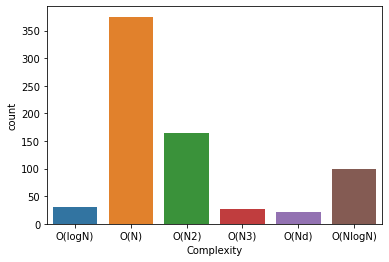

In [ ]:
sns.countplot(df['Complexity'])